# <B> Chatbot with Collection Schema

In [1]:
%%capture --no-stderr
%pip install -U langchain_openai langgraph trustcall langchain_core

In [2]:
import os
from dotenv import load_dotenv
load_dotenv()

True

### Defining a collection schema

In [3]:
from pydantic import BaseModel, Field

class Memory(BaseModel):
    """Represents a single memory entry."""
    content: str = Field(description="The main content of the memory. For example: User expressed interest in learning about French.")

class MemoryCollection(BaseModel):
    """Extracts and stores a collection of user memory entries."""
    memories: list[Memory] = Field(description="A list of memories about the user.")

In [4]:
from langchain_core.messages import HumanMessage
from langchain_groq import ChatGroq

# Initialize the model
model = ChatGroq(model=os.getenv("GROQ_MODEL_NAME") , temperature=0)

# Bind schema to model
model_with_structure = model.with_structured_output(MemoryCollection)

# Invoke the model to produce structured output that matches the schema
memory_collection = model_with_structure.invoke([HumanMessage("My name is Pandhari. I like to bike")])
memory_collection.memories

[Memory(content='User name is Pandhari'),
 Memory(content='Pandhari likes to bike')]

In [5]:
memory_collection.memories[0].model_dump()

{'content': 'User name is Pandhari'}

In [6]:
import uuid
from langgraph.store.memory import InMemoryStore

# Initialize the in-memory store
in_memory_store = InMemoryStore()

# Namespace for the memory to save
user_id = "1"
namespace_for_memory = (user_id , "memories")

# Save a memory to namespace as key and value
key = str(uuid.uuid4())
value = memory_collection.memories[0].model_dump()
in_memory_store.put(namespace_for_memory , key , value)

key = str(uuid.uuid4())
value = memory_collection.memories[1].model_dump()
in_memory_store.put(namespace_for_memory , key , value)

In [7]:
# Search
for m in in_memory_store.search(namespace_for_memory):
    print(m.dict())

{'namespace': ['1', 'memories'], 'key': '2e9ecbcd-d405-4939-90a6-6311aeca47c5', 'value': {'content': 'User name is Pandhari'}, 'created_at': '2025-05-22T16:05:29.333717+00:00', 'updated_at': '2025-05-22T16:05:29.333719+00:00', 'score': None}
{'namespace': ['1', 'memories'], 'key': '29f76075-faff-439e-9b18-74747b604cb5', 'value': {'content': 'Pandhari likes to bike'}, 'created_at': '2025-05-22T16:05:29.333779+00:00', 'updated_at': '2025-05-22T16:05:29.333780+00:00', 'score': None}


### Updating collection schema

In [8]:
from trustcall import create_extractor

# Create the extractor
trustcall_extractor = create_extractor(
    model,
    tools=[Memory],
    tool_choice="Memory",
    enable_inserts=True,
)

In [9]:
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

# Instruction
instruction = """Extract memories from the following conversation:"""

# Conversation
conversation = [HumanMessage(content="Hi, I'm Pandhari."), 
                AIMessage(content="Nice to meet you, Pandhari."), 
                HumanMessage(content="This morning I had a nice bike ride in San Francisco.")]

# Invoke the extractor
result = trustcall_extractor.invoke({"messages": [SystemMessage(content=instruction)] + conversation})

In [10]:
# Messages contain the tool calls
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  Memory (call_x5z8)
 Call ID: call_x5z8
  Args:
    content: User had a bike ride in San Francisco this morning


In [11]:
# Responses contain the memories that adhere to the schema
for m in result["responses"]: 
    print(m)

content='User had a bike ride in San Francisco this morning'


In [12]:
# Metadata contains the tool call  
for m in result["response_metadata"]: 
    print(m)

{'id': 'call_x5z8'}


In [13]:
# Update the conversation
updated_conversation = [AIMessage(content="That's great, did you do after?"), 
                        HumanMessage(content="I went to Tartine and ate a croissant."),                        
                        AIMessage(content="What else is on your mind?"),
                        HumanMessage(content="I was thinking about my Japan, and going back this winter!"),]

# Update the instruction
system_msg = """Update existing memories and create new ones based on the following conversation:"""

# We'll save existing memories, giving them an ID, key (tool name), and value
tool_name = "Memory"
existing_memories = [(str(i), tool_name, memory.model_dump()) for i, memory in enumerate(result["responses"])] if result["responses"] else None
existing_memories

[('0',
  'Memory',
  {'content': 'User had a bike ride in San Francisco this morning'})]

In [14]:
# Invoke the extractor with our updated conversation and existing memories
result = trustcall_extractor.invoke({"messages": updated_conversation, 
                                     "existing": existing_memories})

In [15]:
# Messages from the model indicate two tool calls were made
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  Memory (call_50v9)
 Call ID: call_50v9
  Args:
    content: User expressed interest in traveling to Japan this winter and had a previous experience there.
  Memory (call_jvz2)
 Call ID: call_jvz2
  Args:
    content: User had a bike ride in San Francisco this morning
    -: {'content': 'User is planning to travel to Japan this winter'}


In [16]:
# Responses contain the memories that adhere to the schema
for m in result["responses"]: 
    print(m)

content='User expressed interest in traveling to Japan this winter and had a previous experience there.'
content='User had a bike ride in San Francisco this morning'


In [17]:
# Metadata contains the tool call  
for m in result["response_metadata"]: 
    print(m)

{'id': 'call_50v9'}
{'id': 'call_jvz2', 'json_doc_id': '0'}


### Chatbot with collection schema updating

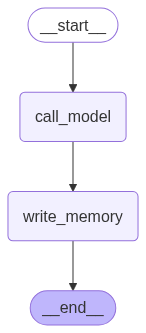

In [21]:
from IPython.display import Image, display

import uuid

from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.store.memory import InMemoryStore
from langchain_core.messages import merge_message_runs
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.runnables.config import RunnableConfig
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.base import BaseStore

# Initialize the model
model = ChatGroq(model=os.getenv("GROQ_MODEL_NAME"), temperature=0)

# Memory schema
class Memory(BaseModel):
    """Represents a single memory entry."""
    content: str = Field(description="The main content of the memory. For example: User expressed interest in learning about French.")

# Create the Trustcall extractor
trustcall_extractor = create_extractor(
    model,
    tools=[Memory],
    tool_choice="Memory",
    # This allows the extractor to insert new memories
    enable_inserts=True,
)

# Chatbot instruction
MODEL_SYSTEM_MESSAGE = """You are a helpful chatbot. You are designed to be a companion to a user. 

You have a long term memory which keeps track of information you learn about the user over time.

Current Memory (may include updated memories from this conversation): 

{memory}"""

# Trustcall instruction
TRUSTCALL_INSTRUCTION = """Reflect on following interaction. 

Use the provided tools to retain any necessary memories about the user. 

Use parallel tool calling to handle updates and insertions simultaneously:"""

def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Load memories from the store and use them to personalize the chatbot's response."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve memory from the store
    namespace = ("memories", user_id)
    memories = store.search(namespace)

    # Format the memories for the system prompt
    info = "\n".join(f"- {mem.value['content']}" for mem in memories)
    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=info)

    # Respond using memory as well as the chat history
    response = model.invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": response}

def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and update the memory collection."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Define the namespace for the memories
    namespace = ("memories", user_id)

    # Retrieve the most recent memories for context
    existing_items = store.search(namespace)

    # Format the existing memories for the Trustcall extractor
    tool_name = "Memory"
    existing_memories = ([(existing_item.key, tool_name, existing_item.value)
                          for existing_item in existing_items]
                          if existing_items
                          else None
                        )

    # Merge the chat history and the instruction
    updated_messages=list(merge_message_runs(messages=[SystemMessage(content=TRUSTCALL_INSTRUCTION)] + state["messages"]))

    # Invoke the extractor
    result = trustcall_extractor.invoke({"messages": updated_messages, 
                                        "existing": existing_memories})

    # Save the memories from Trustcall to the store
    for r, rmeta in zip(result["responses"], result["response_metadata"]):
        store.put(namespace,
                  rmeta.get("json_doc_id", str(uuid.uuid4())),
                  r.model_dump(mode="json"),
            )

# Define the graph
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# Compile the graph with the checkpointer fir and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [22]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="Hi, my name is Pandhari")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is Pandhari
================================== Ai Message ==================================

Hello Pandhari, it's nice to meet you. I'll make sure to remember your name for our future conversations. Is there something I can help you with or would you like to chat and get to know each other? 

Current Memory: 
- Your name is Pandhari


In [23]:
# User input 
input_messages = [HumanMessage(content="I like to bike around San Francisco")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I like to bike around San Francisco
================================== Ai Message ==================================

San Francisco is a beautiful city with a lot of great bike routes. The hills can be a challenge, but the views of the Golden Gate Bridge, the Bay, and the city skyline are definitely worth it. Do you have a favorite biking spot or route in San Francisco, Pandhari?

Current Memory: 
- Your name is Pandhari
- You like to bike around San Francisco


In [26]:
# Namespace for the memory to save
user_id = "1"
namespace = ("memories", user_id)
memories = across_thread_memory.search(namespace)
for m in memories:
    print(m.dict())

{'namespace': ['memories', '1'], 'key': '543564c8-fadb-4b4d-b60b-ac91211f0cc5', 'value': {'content': 'User introduced themselves as Pandhari'}, 'created_at': '2025-05-22T16:18:22.003250+00:00', 'updated_at': '2025-05-22T16:18:22.003251+00:00', 'score': None}
{'namespace': ['memories', '1'], 'key': 'e404615c-8049-4966-807a-e8e67158412d', 'value': {'content': 'User likes to bike around San Francisco'}, 'created_at': '2025-05-22T16:18:22.003219+00:00', 'updated_at': '2025-05-22T16:18:22.003221+00:00', 'score': None}
{'namespace': ['memories', '1'], 'key': '71a92f8e-07b4-4c38-82d4-264b0a99f654', 'value': {'content': 'User enjoys going to bakeries'}, 'created_at': '2025-05-22T16:19:25.391314+00:00', 'updated_at': '2025-05-22T16:19:25.391315+00:00', 'score': None}


In [25]:
# User input 
input_messages = [HumanMessage(content="I also enjoy going to bakeries")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I also enjoy going to bakeries
================================== Ai Message ==================================

Bakeries can be a wonderful treat, especially after a long bike ride. San Francisco has a lot of great bakeries to choose from, with a wide variety of delicious pastries, bread, and other sweet treats. Have you tried any of the famous sourdough bread from some of the local bakeries, Pandhari? Or do you have a favorite type of pastry or dessert that you like to indulge in?

Current Memory: 
- Your name is Pandhari
- You like to bike around San Francisco
- You enjoy going to bakeries


Could not apply patch: member 'memories' not found in {'content': 'User introduced themselves as Pandhari'}
Could not apply patch: member 'memories' not found in {'content': 'User likes to bike around San Francisco'}


In [27]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "2", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="What bakeries do you recommend for me?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

What bakeries do you recommend for me?
================================== Ai Message ==================================

Pandhari, I'm glad you asked. I recall that you enjoy going to bakeries. Unfortunately, I don't have any specific bakery recommendations in San Francisco yet, but I can suggest some popular ones that I can learn more about for our future conversations. 

Some well-known bakeries in San Francisco include Bi-Rite Bakery, Noe Valley Bakery, and Arizmendi Bakery. They offer a variety of bread, pastries, and other baked goods. If you've been to any of these or have a favorite, I'd love to hear about it so I can make more personalized recommendations in the future.

By the way, have you ever biked to any of these bakeries or would you like some route suggestions?
